In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, callbacks, losses
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [47]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

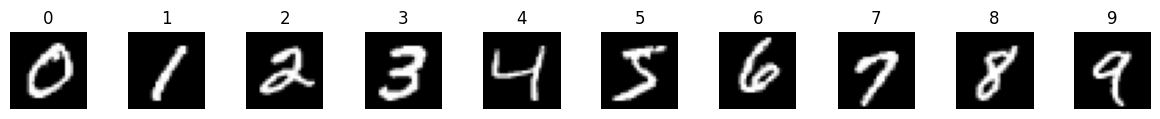

In [11]:
# Define the labels
labels_ = np.arange(10)

# Plot a sample image from each label
fig, axs = plt.subplots(1, 10, figsize=(15, 1))
for i, label in enumerate(labels_):
    ax = axs[i]
    img = x_train[y_train == label][0]
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(str(label))
plt.show()

In [48]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension to the images
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [49]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [32]:
encoder_ = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    layers.Dense(units=1024, activation='relu'),
    layers.Dense(units=1024, activation='relu'),
    layers.Dense(units=64)
])

In [33]:
decoder_ = models.Sequential([
    layers.Dense(units=512, activation='relu'),
    layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid'),
])

In [58]:
class ConvCVAE (tf.keras.Model) :

    def __init__(self,
        encoder,
        decoder,
        label_dim=10,
        batch_size = 32,
        beta = 1,
        image_dim = None):

        super(ConvCVAE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.label_dim = label_dim
        self.batch_size = batch_size
        self.beta = beta
        self.image_dim = image_dim


    def __call__(self, inputs, is_train):

        input_img, input_label, conditional_input = self.conditional_input(inputs)

        z_mean, z_log_var = tf.split(self.encoder(conditional_input, 64, is_train), num_or_size_splits=2, axis=1)
        z_cond = self.reparametrization(z_mean, z_log_var, input_label)
        logits = self.decoder(z_cond, is_train)

        recon_img = tf.nn.sigmoid(logits)

        # Loss computation #
        latent_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1) # KL divergence
        rec_loss = np.prod((32, 32)) * tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(input_img), tf.keras.backend.flatten(recon_img)) # over weighted MSE
        loss = rec_loss + self.beta * latent_loss # weighted ELBO loss
        loss = tf.reduce_mean(loss)

        return {
                    'recon_img': recon_img,
                    'latent_loss': latent_loss,
                    'rec_loss': rec_loss,
                    'loss': loss,
                    'z_mean': z_mean,
                    'z_log_var': z_log_var
                }


    def conditional_input(self, inputs):
        """ Builds the conditional input and returns the original input images, their labels and the conditional input."""

        input_img = tf.keras.layers.InputLayer(input_shape=self.image_dim, dtype = 'float32')(inputs[0])
        input_label = tf.keras.layers.InputLayer(input_shape=(self.label_dim,), dtype = 'float32')(inputs[1])
        labels = tf.reshape(inputs[1], [-1, 1, 1, self.label_dim])
        ones = tf.ones([inputs[0].shape[0]] + self.image_dim[0:-1] + [self.label_dim])
        labels = ones * labels
        conditional_input = tf.keras.layers.InputLayer(input_shape=(self.image_dim[0], self.image_dim[1], self.image_dim[2] + self.label_dim), dtype = 'float32')(tf.concat([inputs[0], labels], axis=3))

        return input_img, input_label, conditional_input


    def reparametrization(self, z_mean, z_log_var, input_label):

        eps = tf.random.normal(shape = (input_label.shape[0], 64), mean = 0.0, stddev = 1.0)
        z = z_mean + tf.math.exp(z_log_var * .5) * eps
        z_cond = tf.concat([z, input_label], axis=1)

        return z_cond

In [35]:
def train_step(data, model, optimizer):


    with tf.GradientTape() as tape:

        model_output = model(data, is_train = True)

    trainable_variables = model.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    total_loss = model_output['loss'].numpy().mean()
    recon_loss = model_output['rec_loss'].numpy().mean()
    latent_loss = model_output['latent_loss'].numpy().mean()

    return total_loss, recon_loss, latent_loss

In [59]:
model = ConvCVAE(
                encoder_,
                decoder_,
                image_dim = [28, 28, 1])

# Optiizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [52]:
# Define the data augmentation pipeline
datagen = image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [53]:
train_losses = []
train_recon_errors = []
train_latent_losses = []
loss = []
reconstruct_loss = []
latent_loss = []

step_index = 0
n_batches = 32
n_epochs = 30

In [44]:
import time

In [60]:
for epoch in range(5):
    start_time = time.perf_counter()

    # Train Step Loop
    for step_index, inputs in enumerate(datagen.flow(x_train, y_train, batch_size=64)):
      total_loss, recon_loss, lat_loss = train_step(inputs, model, optimizer)
      train_losses.append(total_loss)
      train_recon_errors.append(recon_loss)
      train_latent_losses.append(lat_loss)

      if step_index + 1 == n_batches:
          break

    loss.append(np.mean(train_losses, 0))
    reconstruct_loss.append(np.mean(train_recon_errors, 0))
    latent_loss.append(np.mean(train_latent_losses, 0))

    exec_time = time.perf_counter() - start_time
    print("Execution time: %0.3f \t Epoch %i: loss %0.4f | reconstr loss %0.4f | latent loss %0.4f"
                        % (exec_time, epoch, loss[epoch], reconstruct_loss[epoch], latent_loss[epoch]))

InvalidArgumentError: required broadcastable shapes [Op:Mul]